Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [374]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [375]:
RANDOM_SEED = 42

In [376]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [377]:
data = pd.read_csv('data/df_moscow_all_upd.csv')
data.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,67.0349,1.3200,20155.000000,1.0538,0,0,-1
1,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,58.3529,1.2527,21239.338735,1.0252,0,0,-1
2,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,62.7078,1.2218,21774.570269,1.0427,0,0,-1
3,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,64.7362,1.1718,22704.345558,1.0305,0,0,-1
4,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,72.1464,1.1371,23396.829332,1.0491,0,0,-1


In [378]:
# Есть странные колонки заканчивающиеся на .1 и .2 - объединяем с нормальным кодом
for col in [c for c in data.columns if c.endswith('.1') or c.endswith('.2')]:
    if col[0:8] in data.columns :
        data[col[0:8]] = data[col[0:8]] + data[col]
        data.drop(col, axis=1, inplace=True)

In [379]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65374 entries, 0 to 65373
Data columns (total 130 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    inn                65374 non-null  int64  
 1    ogrn               65374 non-null  int64  
 2    main_okved         65374 non-null  object 
 3    name               65374 non-null  object 
 4    address            65374 non-null  object 
 5    type               65374 non-null  object 
 6    status             65374 non-null  object 
 7    okved              65374 non-null  object 
 8    date_reg           65374 non-null  object 
 9    comments           11764 non-null  object 
 10   year               65374 non-null  int64  
 11   ind_1250           65374 non-null  int64  
 12   ind_1230           65374 non-null  int64  
 13   ind_1600           65374 non-null  int64  
 14   ind_1300           65374 non-null  int64  
 15   ind_1520           65374 non-null  int64  
 16   in

In [380]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['ogrn'] = data['ogrn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['address'] = data['address'].astype(str)
data['type'] = data['type'].astype(str)
data['status'] = data['status'].astype(str)
#data['okved'] = data['okved'].apply(lambda x: x[1:-1].split(','))
data['date_reg'] = pd.to_datetime(data['date_reg'])
data['comments'] = data['comments'].astype(str)
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65374 entries, 0 to 65373
Data columns (total 130 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    inn                65374 non-null  object        
 1    ogrn               65374 non-null  object        
 2    main_okved         65374 non-null  object        
 3    name               65374 non-null  object        
 4    address            65374 non-null  object        
 5    type               65374 non-null  object        
 6    status             65374 non-null  object        
 7    okved              65374 non-null  object        
 8    date_reg           65374 non-null  datetime64[ns]
 9    comments           65374 non-null  object        
 10   year               65374 non-null  int64         
 11   ind_1250           65374 non-null  float64       
 12   ind_1230           65374 non-null  float64       
 13   ind_1600           65374 non-null  float64  

In [381]:
for col in [c for c in data.columns if c.startswith('ind_')]:
    data[col] = data[col] / data['currency']

In [382]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
0,7721452574,2016,2016,300.664281,75.244388,53.554193,214.992489,228.910612,300.664281,0.0,...,0.0,0.0,0.0,0.0,-4.475281,0.0,0.0,0.0,0.0,0.0
1,7721452574,2017,2016,300.664281,75.244388,53.554193,214.992489,228.910612,300.664281,0.0,...,0.0,0.0,0.0,0.0,-4.475281,0.0,0.0,0.0,0.0,0.0
2,7721452574,2018,2016,300.664281,75.244388,53.554193,214.992489,228.910612,300.664281,0.0,...,0.0,0.0,0.0,0.0,-4.475281,0.0,0.0,0.0,0.0,0.0
3,7721452574,2019,2016,300.664281,75.244388,53.554193,214.992489,228.910612,300.664281,0.0,...,0.0,0.0,0.0,0.0,-4.475281,0.0,0.0,0.0,0.0,0.0
4,7721452574,2020,2016,300.664281,75.244388,53.554193,214.992489,228.910612,300.664281,0.0,...,0.0,0.0,0.0,0.0,-4.475281,0.0,0.0,0.0,0.0,0.0


In [383]:
data.loc[data['inv_sum'] < 0, ['inv_sum', 'inn', 'date_reg']]

,inv_sum,inn,date_reg
2701,-0.159470,9731000027,2018-04-09
2702,-0.159470,9731000027,2018-04-09
2703,-0.159470,9731000027,2018-04-09
3952,-0.085686,9715309555,2017-11-29
3953,-0.085686,9715309555,2017-11-29
3954,-0.085686,9715309555,2017-11-29
3955,-0.085686,9715309555,2017-11-29
4033,-1.028227,7720403398,2017-11-20
4034,-1.028227,7720403398,2017-11-20
4035,-1.028227,7720403398,2017-11-20


In [384]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
57635,1102068218,2011,130.055738,130.055738,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57636,1102068218,2012,-72.202747,57.852992,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57637,1102068218,2013,-74.290379,-16.437388,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57638,1102068218,2014,-29.462517,-45.899905,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57639,1102068218,2015,-30.676910,-76.576815,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [385]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
inn,,,,,,,,,,,,,,,,,,,,,
1102068218,2020,-3.090937,29.351412,2011,2346.141544,5.240341,3.402819,230.711121,2269.237837,2346.141544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650329732,2021,193.037455,298.047714,2016,30.939108,1.491760,30.014216,3.266955,0.492281,30.939108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655298774,2020,-88.348137,777.847904,2014,181.433929,0.026027,362.295265,542.271685,0.000000,181.433929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655300448,2020,45.269064,77.171960,2014,32.299456,0.182189,2.498588,12.883345,5.179365,32.299456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310172571,2020,180.618853,771.819554,2013,162.647576,83.050741,93.067069,-328.937453,107.699071,162.647576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [386]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [387]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result
38604,7728831839,1137746069691,72.1,"ООО ""ЛИКОН""","117292, г. Москва, ул. Профсоюзная, 26/44, подв пом II ком 1 оф 31",коммерческая,действующая,"['26.11', '26.70.1', '33.13', '46.14', '46.90']",2013-02-01,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.313991
4425,7724421302,5177746035154,59.20,"ООО ""КОЛОР МЬЮЗИК""","115230, г. Москва, проезд Хлебозаводский, 7 стр 9, эт 8 пом XV оф 801Ч",коммерческая,действующая,"['18.20', '46.43.3', '46.52.3', '47.63', '59.20.2', '59.20.3', '71.11', '71.11.3', '73.11', '73.20']",2017-10-04,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.889138,-140.501032


In [388]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result
1346,7704446482,5177746104531,62.01,"ООО ""ВЭБАРТ""","119019, г. Москва, пер Большой Афанасьевский, 22, эт 3/ пом 15",коммерческая,действующая,"['18.13', '58.19', '62.02', '62.09', '63.11', '63.12', '63.91', '63.99', '73.11', '74.10']",2017-10-23,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778546,-0.384393
11639,9717082927,1197746349668,62.01,"ООО ""МАКВЕС ГРУПП""","129164, г. Москва, ул. Ярославская, 8 корп. 3, эт. 5, помещ. I, ком. 28, оф. 523",коммерческая,действующая,"['46.14.1', '46.14.9', '46.51', '46.66', '46.69', '46.90', '47.19', '47.41', '47.41.4', '47.59.1']",2019-05-29,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.694656,1.673709


In [389]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result,target
861,7703438087,5177746265439,62.01,"ООО ""УЧИ.РУ ПЛЮС""","121069, г. Москва, пер Столовый, 4 стр. 4, кв. 1",коммерческая,действующая,"['47.19', '47.41', '47.61', '47.62', '47.65', '47.78', '47.91', '62.02', '62.03', '62.09']",2017-11-28,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
6984,7726352816,1157746847279,62.01,"ООО ""КОНФИДЕНТ СЕРВИС""","117556, г. Москва, б-р Симферопольский, 3Г, оф. 102",коммерческая,действующая,"['46.51', '62.02', '62.02.1', '62.02.2', '62.02.3', '62.02.4', '62.02.9', '62.03', '62.03.1', '62.03.11']",2015-09-15,nan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.930126,-91.897317,5


In [390]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[temp['type'] == 'коммерческая', ['inn', 'main_okved', 'inv_sum', 'target'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,inv_sum,target,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
0,1102068218,62.01,2346.141544,-1,5.240341,3.402819,230.711121,2269.237837,2346.141544,747.429170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1650329732,62.01,30.939108,4,1.491760,30.014216,3.266955,0.492281,30.939108,3.878577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1655298774,62.01,181.433929,1,0.026027,362.295265,542.271685,0.000000,181.433929,181.017498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1655300448,62.09,32.299456,1,0.182189,2.498588,12.883345,5.179365,32.299456,8.406708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2310172571,62.09,162.647576,5,83.050741,93.067069,-328.937453,107.699071,162.647576,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [391]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 12401
Количество уникальных значений: 12401
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count          12401
unique         12401
top       1102068218
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1102068218    1
7730206046    1
7730224447    1
7730225401    1
7730227078    1
7730230546    1
7730230585    1
7730230955    1
7730231236    1
7730231684    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 12401
Количество уникальных значений: 65
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     12401
unique       65
top       62.01
freq       4259
Name: 

In [392]:
work_df = work_df[work_df['inv_sum'] > 0]

In [393]:
# np.log(work_df['inv_sum']).hist(bins=100)

In [394]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

### Первая модель - LR

In [395]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,inv_ind_2120,inv_ind_2350,inv_ind_1210,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
9002,-0.286206,-0.050464,-0.099511,-0.010858,-0.105910,-0.015000,-0.118437,0.106296,0.067886,-0.067255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12019,-1.403361,-0.050729,-0.102834,-0.010869,-0.108217,-0.015053,-0.122266,0.108641,0.068539,-0.067255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [396]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,inv_ind_2120,inv_ind_2350,inv_ind_1210,...,x0_90.02,x0_90.03,x0_90.04,x0_91.01,x0_91.02,x0_91.03,x0_91.04,x0_93.1,x0_93.2,x0_94.12
10960,-1.720528,-0.050698,-0.102819,-0.010871,-0.108217,-0.015055,-0.122266,0.110006,0.070331,-0.067216,...,0,0,0,0,0,0,0,0,0,0
6729,0.522128,-0.048550,-0.075930,-0.010384,-0.107285,-0.014553,-0.036738,0.031977,0.065160,-0.063727,...,0,0,0,0,0,0,0,0,0,0


In [397]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [398]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((10712, 171), (10712,), (8569, 171), (8569,), (2143, 171), (2143,))

In [399]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7007383110228096

В принципе результат не плохой - можно работать дальше

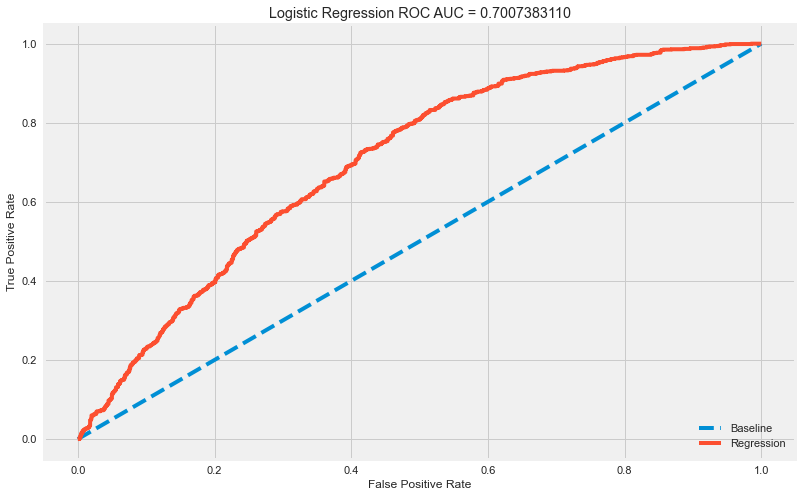

In [400]:
show_roc_auc(y_valid, y_prob[:, 1])

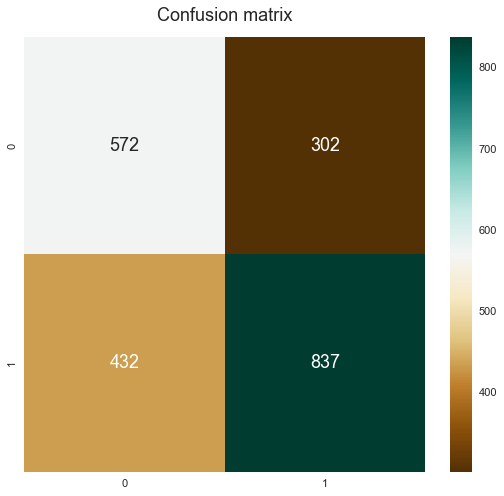

In [401]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

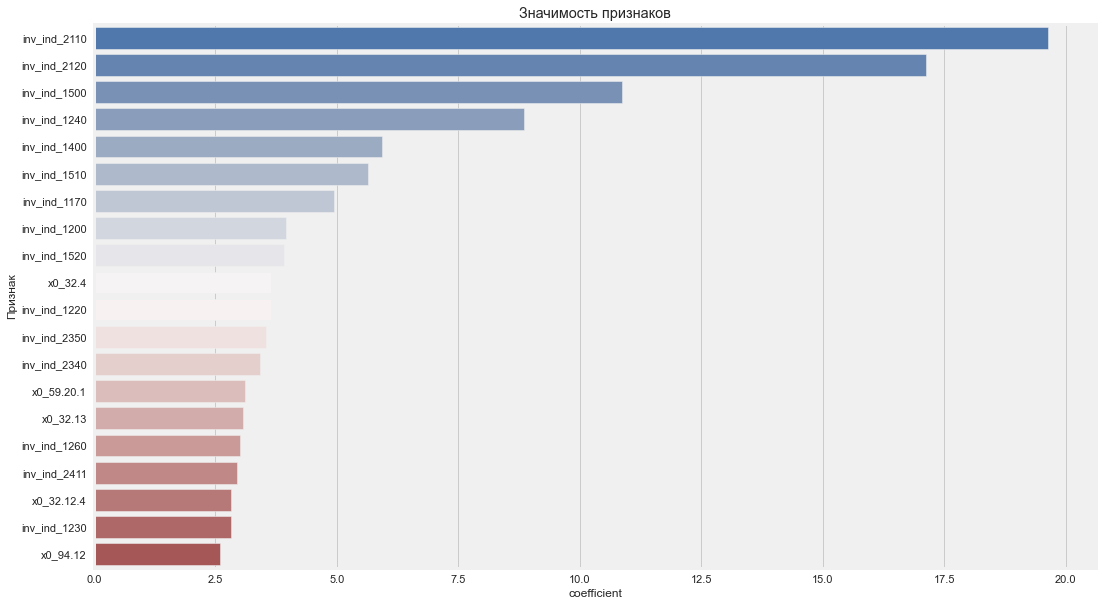

In [402]:
show_lr_Importance(lr, X.columns)

### LGBMClassifier

In [403]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7438245263021663

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

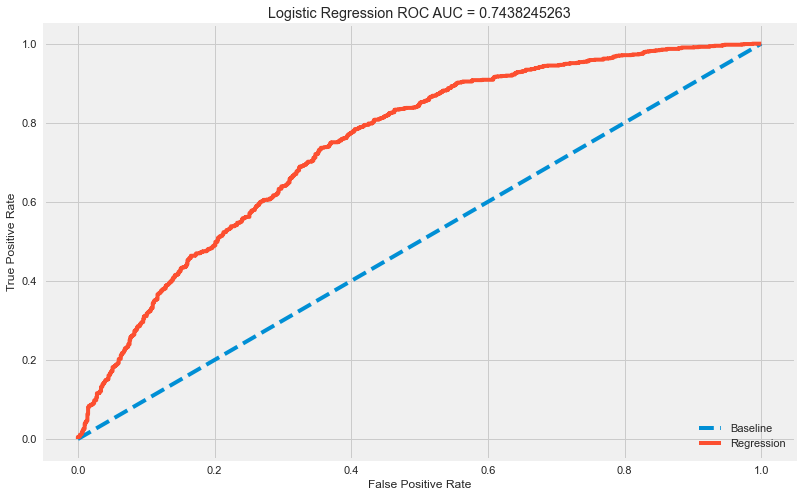

In [404]:
show_roc_auc(y_valid, y_prob[:, 1])

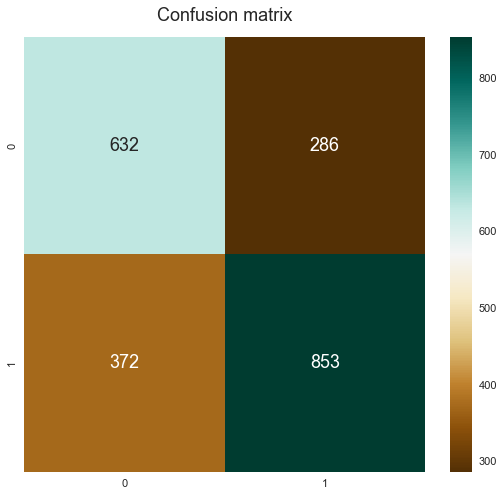

In [405]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

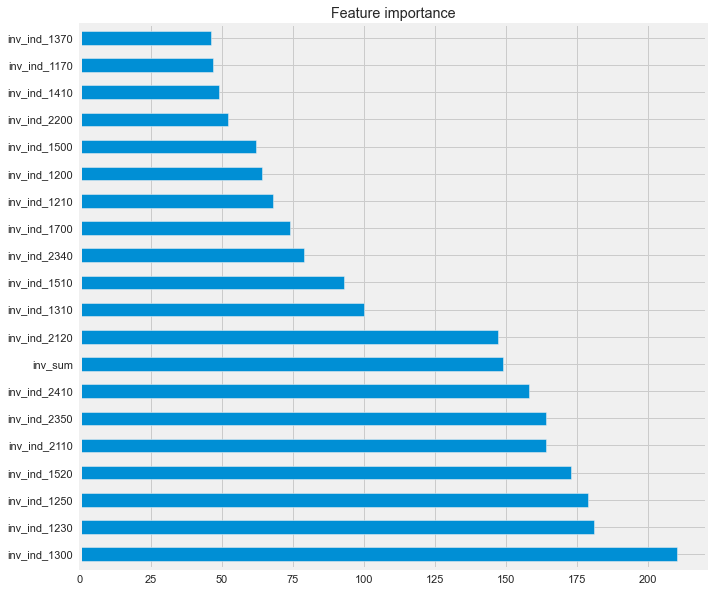

In [406]:
plot_feature_importances(model.feature_importances_, X.columns)

### Предсказание срока выхода из убытков

In [417]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
# features = ['inv_sum']
features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[features] = preprocessing.StandardScaler().fit_transform(work_df[features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved']]).astype(int)
y = work_df['target']
X.shape, y.shape

((10712, 70), (10712,))

In [418]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((10712, 70), (10712,), (8569, 70), (8569,), (2143, 70), (2143,))

In [419]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr', average='weighted')

0.6514006834523384

In [420]:
cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovr_weighted')

array([0.66083292, 0.65851662, 0.65475594, 0.64944905, 0.63372519])

На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

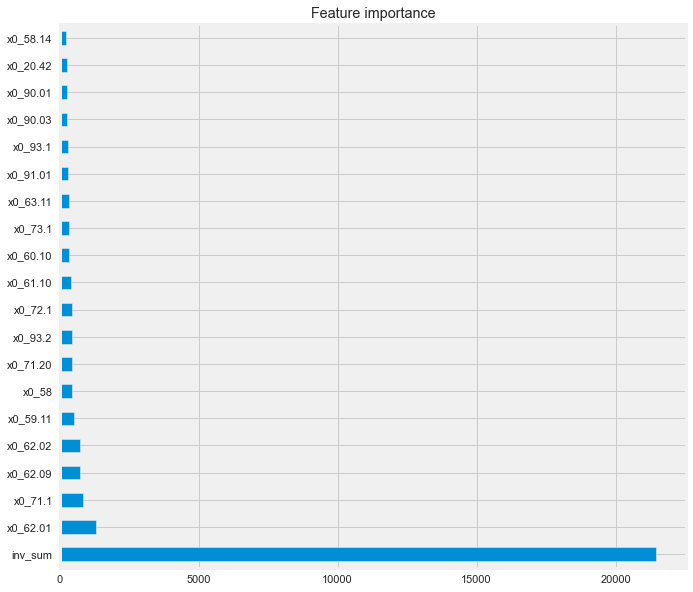

In [411]:
plot_feature_importances(model.feature_importances_, X.columns)

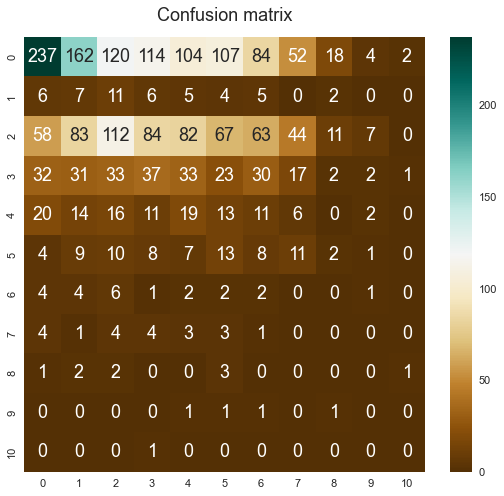

In [412]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [413]:
list(zip(y_pred, y_valid))[100:110]

[(-1, -1),
 (5, 1),
 (0, -1),
 (7, -1),
 (3, 0),
 (8, 4),
 (1, -1),
 (0, 3),
 (1, 1),
 (7, 1)]

In [414]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

1.327493751703704

In [415]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(-0.0, -1),
 (1.0, 1),
 (-0.0, -1),
 (1.0, -1),
 (1.0, 0),
 (2.0, 4),
 (1.0, -1),
 (1.0, 3),
 (0.0, 1),
 (1.0, 1)]

In [416]:
np.unique(np.round(y_pred), return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([  68,  983, 1004,   88]))